####  Original Source: [Pinecone LangChain Handbook](https://pinecone.io/learn/langchain)

# Retrieval Augmentation

**L**arge **L**anguage **M**odels (LLMs) have a data freshness problem. The most powerful LLMs in the world, like GPT-4, have no idea about recent world events.

The world of LLMs is frozen in time. Their world exists as a static snapshot of the world as it was within their training data.

A solution to this problem is *retrieval augmentation*. The idea behind this is that we retrieve relevant information from an external knowledge base and give that information to our LLM. In this notebook we will learn how to do that.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/truera/trulens/blob/main/trulens_eval/examples/vector-dbs/pinecone/langchain-retrieval-augmentation-with-trulens.ipynb)

To begin, we must install the prerequisite libraries that we will be using in this notebook. If we install all libraries we will find a conflict in the Hugging Face `datasets` library so we must install everything in a specific order like so:

In [ ]:
! pip install -qU \
    datasets==2.12.0 \
    apache_beam \
    mwparserfromhell

## Building the Knowledge Base

In [ ]:
from datasets import load_dataset

data = load_dataset("wikipedia", "20220301.simple", split='train[:10000]')
data

In [ ]:
data[6]

We can also print the titles of the first few articles to see what kinds of topics we're dealing with.

In [ ]:
for i in range(0,100):
    print (str(i) + ":" + data[i]['title'])

Now we install the remaining libraries:

In [ ]:
!pip install -qU \
  langchain \
  openai \
  tiktoken \
  "pinecone-client[grpc]"==2.2.1

---

🚨 _Note: the above `pip install` is formatted for Jupyter notebooks. If running elsewhere you may need to drop the `!`._

---

Every record contains *a lot* of text. Our first task is therefore to identify a good preprocessing methodology for chunking these articles into more "concise" chunks to later be embedding and stored in our Pinecone vector database.

For this we use LangChain's `RecursiveCharacterTextSplitter` to split our text into chunks of a specified max length.

In [ ]:
import tiktoken

tiktoken.encoding_for_model('gpt-3.5-turbo')

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

tiktoken_len("hello I am a chunk of text and using the tiktoken_len function "
             "we can find the length of this chunk of text in tokens")

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

In [ ]:
chunks = text_splitter.split_text(data[6]['text'])[:3]
chunks

In [ ]:
tiktoken_len(chunks[0]), tiktoken_len(chunks[1]), tiktoken_len(chunks[2])

Using the `text_splitter` we get much better sized chunks of text. We'll use this functionality during the indexing process later. Now let's take a look at embedding.

## Creating Embeddings

Building embeddings using LangChain's OpenAI embedding support is fairly straightforward. We first need to add our [OpenAI api key]() by running the next cell:

In [ ]:
# get openai api key from platform.openai.com, and set it as an environment variable if you haven't already
import os
os.environ['OPENAI_API_KEY'] = 'SET OPENAI_API_KEY'
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

*(Note that OpenAI is a paid service and so running the remainder of this notebook may incur some small cost)*

After initializing the API key we can initialize our `text-embedding-ada-002` embedding model like so:

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings

model_name = 'text-embedding-ada-002'

embed = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

Now we embed some text like so:

In [ ]:
texts = [
    'this is the first chunk of text',
    'then another second chunk of text is here'
]

res = embed.embed_documents(texts)
len(res), len(res[0])

From this we get *two* (aligning to our two chunks of text) 1536-dimensional embeddings.

Now we move on to initializing our Pinecone vector database.

## Vector Database

To create our vector database we first need a [free API key from Pinecone](https://app.pinecone.io). Then we initialize like so:

In [ ]:
index_name = 'langchain-retrieval-augmentation'

In [ ]:
import pinecone

# find API key in console at app.pinecone.io
PINECONE_API_KEY = 'SET PINECONE_API_KEY'
# find ENV (cloud region) next to API key in console
PINECONE_ENVIRONMENT = 'SET PINECONE_ENVIRONMENT'

pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_ENVIRONMENT
)

if index_name not in pinecone.list_indexes():
    # we create a new index
    pinecone.create_index(
        name=index_name,
        metric='cosine',
        dimension=len(res[0])  # 1536 dim of text-embedding-ada-002
    )

Then we connect to the new index:

In [ ]:
index = pinecone.Index(index_name)

index.describe_index_stats()

We should see that the new Pinecone index has a `total_vector_count` of `0`, as we haven't added any vectors yet.

## Indexing

We can perform the indexing task using the LangChain vector store object. But for now it is much faster to do it via the Pinecone python client directly. We will do this in batches of `100` or more.

In [ ]:
# If you are creating your index for the first time, set this flag to True
create_index = False
if create_index == True:
    from tqdm.auto import tqdm
    from uuid import uuid4

    batch_limit = 100

    texts = []
    metadatas = []

    for i, record in enumerate(tqdm(data)):
        # first get metadata fields for this record
        metadata = {
            'wiki-id': str(record['id']),
            'source': record['url'],
            'title': record['title']
        }
        # now we create chunks from the record text
        record_texts = text_splitter.split_text(record['text'])
        # create individual metadata dicts for each chunk
        record_metadatas = [{
            "chunk": j, "text": text, **metadata
        } for j, text in enumerate(record_texts)]
        # append these to current batches
        texts.extend(record_texts)
        metadatas.extend(record_metadatas)
        # if we have reached the batch_limit we can add texts
        if len(texts) >= batch_limit:
            ids = [str(uuid4()) for _ in range(len(texts))]
            embeds = embed.embed_documents(texts)
            index.upsert(vectors=zip(ids, embeds, metadatas))
            texts = []
            metadatas = []

    if len(texts) > 0:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embed.embed_documents(texts)
        index.upsert(vectors=zip(ids, embeds, metadatas))

We've now indexed everything. We can check the number of vectors in our index like so:

In [ ]:
index.describe_index_stats()

## Creating a Vector Store and Querying

Now that we've build our index we can switch back over to LangChain. We start by initializing a vector store using the same index we just built. We do that like so:

In [ ]:
from langchain.vectorstores import Pinecone

text_field = "text"

# switch back to normal index for langchain
index = pinecone.Index(index_name)

vectorstore = Pinecone(
    index, embed.embed_query, text_field
)

In [ ]:
query = "who was Benito Mussolini?"

vectorstore.similarity_search(
    query,  # our search query
    k=3  # return 3 most relevant docs
)

All of these are good, relevant results. But what can we do with this? There are many tasks, one of the most interesting (and well supported by LangChain) is called _"Generative Question-Answering"_ or GQA.

## Generative Question-Answering

In GQA we take the query as a question that is to be answered by a LLM, but the LLM must answer the question based on the information it is seeing being returned from the `vectorstore`.

To do this we initialize a `RetrievalQA` object like so:

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain

# completion llm
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo',
    temperature=0.0
)

qa_with_sources = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

In [ ]:
qa_with_sources(query)

## Wrap with TruChain
We can now start tracking this example with TruEra and some feedback functions to understand how the app is behaving.

In [ ]:
from trulens_eval import Feedback
from trulens_eval import Select
from trulens_eval import Tru
from trulens_eval import feedback
from trulens_eval.keys import *
from trulens_eval.schema import FeedbackMode
from trulens_eval.feedback import Feedback

import numpy as np

tru = Tru()

In [ ]:
#hugs = feedback.Huggingface()
openai = feedback.OpenAI()

# Language match between question/answer.
#f_lang_match = Feedback(hugs.language_match).on_input_output()
# By default this will evaluate feedback on main app input and main app output.

# Question/answer relevance between overall question and answer.
f_qa_relevance = Feedback(openai.relevance).on_input_output()
# By default this will evaluate feedback on main app input and main app output.

# Question/statement relevance between question and each context chunk.
f_qs_relevance = feedback.Feedback(openai.qs_relevance).on_input().on(
    Select.Record.app.combine_documents_chain._call.args.inputs.input_documents[:].page_content
).aggregate(np.mean)
# First feedback argument is set to main app input, and the second is taken from
# the context sources as passed to an internal `combine_docs_chain._call`.


In [ ]:
tc_v01 = Tru().Chain(app_id = 'v01_langchain_qa', chain=qa_with_sources, feedbacks=[f_qa_relevance, f_qs_relevance], feedback_mode=FeedbackMode.WITH_APP)

In [ ]:
tc_v01(query)

In [ ]:
tru.run_dashboard()

We can ask a few more questions and log them

In [ ]:
tc_v01("Which year did Cincinatti become the Capital of Ohio?")

In [ ]:
tc_v01("Which year was Hawaii's state song written?")

In [ ]:
tc_v01("How many countries are there in the world?")

In [ ]:
tc_v01("How many total major trophies has manchester united won?")

In [ ]:
tc_v01("Name some famous dental floss brands?")

Most of these answers are pretty good. However, if we look at the last one, it turns out that the source article doesn't contain any information about famous floss brands.

In order to do better on these kinds of examples, we can customize our prompt template to be more specific to the contents. You can find the original prompt under the Prompt Details section of the Evaluations tab.

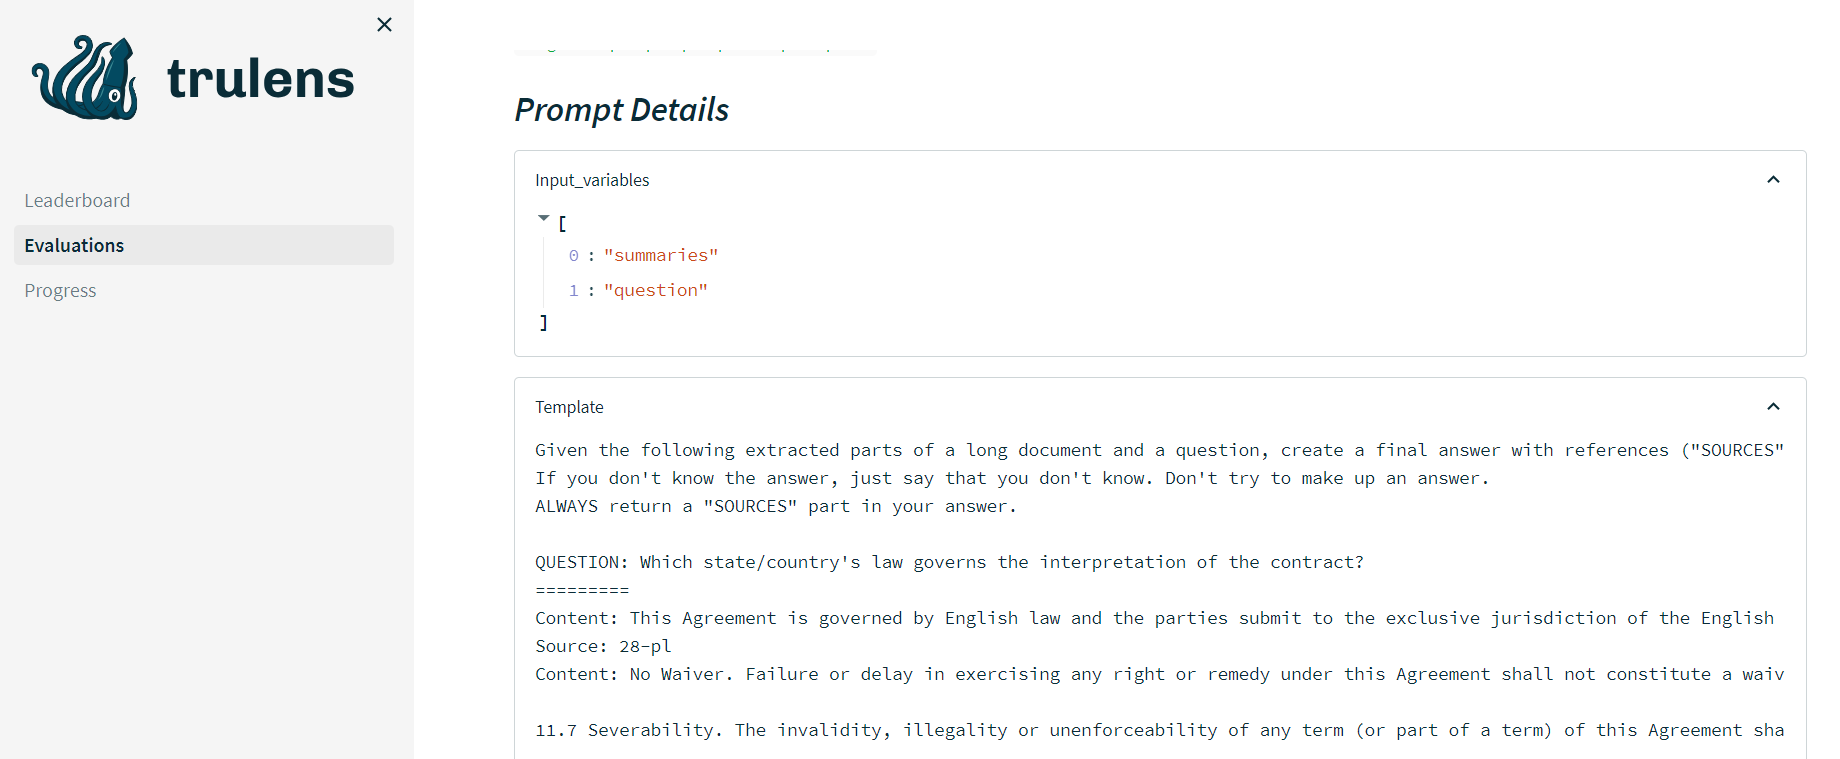

In [ ]:
from langchain.prompts import PromptTemplate
prompt_template = """Given the following contents extracted from a long document and a question, create a final answer with references ("SOURCES"). 
If the answer cannot be given based on the contents, just say that you don't know. Don't try to make up an answer.
ALWAYS return a "SOURCES" part in your answer.

QUESTION: Which state/country's law governs the interpretation of the contract?
=========
Content: This Agreement is governed by English law and the parties submit to the exclusive jurisdiction of the English courts in  relation to any dispute (contractual or non-contractual) concerning this Agreement save that either party may apply to any court for an  injunction or other relief to protect its Intellectual Property Rights.
Source: 28-pl
Content: No Waiver. Failure or delay in exercising any right or remedy under this Agreement shall not constitute a waiver of such (or any other)  right or remedy.

11.7 Severability. The invalidity, illegality or unenforceability of any term (or part of a term) of this Agreement shall not affect the continuation  in force of the remainder of the term (if any) and this Agreement.

11.8 No Agency. Except as expressly stated otherwise, nothing in this Agreement shall create an agency, partnership or joint venture of any  kind between the parties.

11.9 No Third-Party Beneficiaries.
Source: 30-pl
Content: (b) if Google believes, in good faith, that the Distributor has violated or caused Google to violate any Anti-Bribery Laws (as  defined in Clause 8.5) or that such a violation is reasonably likely to occur,
Source: 4-pl
=========
FINAL ANSWER: This Agreement is governed by English law.
SOURCES: 28-pl

QUESTION: What did the president say about Michael Jackson?
=========
Content: Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  

Last year COVID-19 kept us apart. This year we are finally together again. 

Tonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. 

With a duty to one another to the American people to the Constitution. 

And with an unwavering resolve that freedom will always triumph over tyranny. 

Six days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. 

He thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. 

He met the Ukrainian people. 

From President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world. 

Groups of citizens blocking tanks with their bodies. Everyone from students to retirees teachers turned soldiers defending their homeland.
Source: 0-pl
Content: And we won’t stop. 

We have lost so much to COVID-19. Time with one another. And worst of all, so much loss of life. 

Let’s use this moment to reset. Let’s stop looking at COVID-19 as a partisan dividing line and see it for what it is: A God-awful disease.  

Let’s stop seeing each other as enemies, and start seeing each other for who we really are: Fellow Americans.  

We can’t change how divided we’ve been. But we can change how we move forward—on COVID-19 and other issues we must face together. 

I recently visited the New York City Police Department days after the funerals of Officer Wilbert Mora and his partner, Officer Jason Rivera. 

They were responding to a 9-1-1 call when a man shot and killed them with a stolen gun. 

Officer Mora was 27 years old. 

Officer Rivera was 22. 

Both Dominican Americans who’d grown up on the same streets they later chose to patrol as police officers. 

I spoke with their families and told them that we are forever in debt for their sacrifice, and we will carry on their mission to restore the trust and safety every community deserves.
Source: 24-pl
Content: And a proud Ukrainian people, who have known 30 years  of independence, have repeatedly shown that they will not tolerate anyone who tries to take their country backwards.  

To all Americans, I will be honest with you, as I’ve always promised. A Russian dictator, invading a foreign country, has costs around the world. 

And I’m taking robust action to make sure the pain of our sanctions  is targeted at Russia’s economy. And I will use every tool at our disposal to protect American businesses and consumers. 

Tonight, I can announce that the United States has worked with 30 other countries to release 60 Million barrels of oil from reserves around the world.  

America will lead that effort, releasing 30 Million barrels from our own Strategic Petroleum Reserve. And we stand ready to do more if necessary, unified with our allies.  

These steps will help blunt gas prices here at home. And I know the news about what’s happening can seem alarming. 

But I want you to know that we are going to be okay.
Source: 5-pl
Content: More support for patients and families. 

To get there, I call on Congress to fund ARPA-H, the Advanced Research Projects Agency for Health. 

It’s based on DARPA—the Defense Department project that led to the Internet, GPS, and so much more.  

ARPA-H will have a singular purpose—to drive breakthroughs in cancer, Alzheimer’s, diabetes, and more. 

A unity agenda for the nation. 

We can do this. 

My fellow Americans—tonight , we have gathered in a sacred space—the citadel of our democracy. 

In this Capitol, generation after generation, Americans have debated great questions amid great strife, and have done great things. 

We have fought for freedom, expanded liberty, defeated totalitarianism and terror. 

And built the strongest, freest, and most prosperous nation the world has ever known. 

Now is the hour. 

Our moment of responsibility. 

Our test of resolve and conscience, of history itself. 

It is in this moment that our character is formed. Our purpose is found. Our future is forged. 

Well I know this nation.
Source: 34-pl
=========
FINAL ANSWER: The president did not mention Michael Jackson.
SOURCES:

QUESTION: {question}
=========
{summaries}
=========
FINAL ANSWER:

"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["summaries", "question"]
)


chain_type_kwargs = {"prompt": PROMPT}

In [ ]:
from langchain.chains import RetrievalQAWithSourcesChain

qa_with_sources_v2 = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
    chain_type_kwargs=chain_type_kwargs
)


In [ ]:
tc_v02 = Tru().Chain(app_id = 'v02_langchain_qa', chain=qa_with_sources_v2, feedbacks=[f_qa_relevance, f_qs_relevance], feedback_mode=FeedbackMode.WITH_APP)

In [ ]:
tc_v02("Name some famous dental floss brands?")

In [ ]:
tc_v02("Which year did Cincinatti become the Capital of Ohio?")

In [ ]:
tc_v02("Which year was Hawaii's state song written?")

In [ ]:
tc_v02("How many countries are there in the world?")

In [ ]:
tc_v02("How many total major trophies has manchester united won?")

---